In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import auc
import warnings

import torchvision.models as models
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from scipy.spatial.distance import cosine
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit

**A partir de la base de datos proporcionada, se realizará un programa que permita identificar las huellas del mismo usuario y descartar el resto, dando información cuantitativa de la similitud entre las huellas, pudiendo utilizar openCV, numpy, os, PyTorch,..., pero no funciones descargadas especialmente para trabajar con huellas dactilares.**



## Borrar

Se obtendrá la función densidad de probabilidad, la curva DET, la curva ROC., el valor EER y el valor AUC.

Se realizará un póster (una única transparencia) y se presentará durante la última semana de clase. Además, se entregará el código usado.

En la presentación tienen que tratarse los siguientes puntos:

-Hipótesis de partida.

-Metodología utilizada y explicación de su desarrollo.

-Resultados (curvas, EER y AUC).

-Conclusiones.

-Fuentes principales consultadas.

## 1. Limpieza del dataset

En este *notebook* se realizan dos tipos de limpieza del dataset. La primera de ellas consiste en utilizar el histograma de la imagen binarizada para quedarse únicamente con la huella y la segunda de ellas en utilizar la librería `scikit-learn` para resaltar los patrones de la huella.

In [2]:
sample_path = r"\BaseDatosNISTsd09_pr"
output_hand_dataset = "./datasets/hand_dataset"
output_frangi_dataset = "./datasets/frangi_dataset"
sample_path = os.getcwd()+sample_path
subfolders= os.listdir(sample_path)

### 1.1. Extracción de las huellas mediante el histograma de la imagen

En el archivo `/clean_dataset/hand_cleaning.py` se encuentra el código implementado para la limpieza donde la función principal es `build_dataset`. Dicha función consiste en lo siguiente:
- Parámetros de entrada:
    - `sample_path`: Ruta base donde se encuentran las carpetas con las imágenes de entrada.
    - `subfolders`: Lista de subcarpetas dentro de sample_path que contienen las imágenes a procesar.
    - `dataset_pat`h`: Ruta donde se guardarán las imágenes procesadas.
- Flujo del programa:
    1. Lectura de la imagen
    2. Binarización
    3. Recorte de la imagen donde se determinan los valores donde se debe realizar el corte donde se deja el 5% fuera de la imagen.
    4. Redimensionamiento y escritura

In [3]:
from clean_dataset.hand_cleaning import build_dataset

build_dataset(sample_path, subfolders, output_hand_dataset)

### 1.2. Extracción de las huellas mediante el uso de `scikit-learn`

En el archivo `/clean_dataset/scikit_cleaning.py` se encuentra el código implementado para la limpieza donde la función principal es `build_dataset_franfi`. Dicha función consiste en lo siguiente:
- Parámetros de entrada:
    - `sample_path`: Ruta base donde se encuentran las carpetas con las imágenes de entrada.
    - `subfolders`: Lista de subcarpetas dentro de sample_path que contienen las imágenes a procesar.
    - `dataset_path`: Ruta donde se guardarán las imágenes procesadas.
- Flujo del programa:
    1. Lectura de la imagen
    2. Reducción de ruido mediante el filtro `GaussianBlur` de `OpenCV`.
    3. Ecualización del histograma mediante `equializeHist`.
    4. Realzar la imagen con el filtro de Frangi convirtiéndola a escala de grises, aplicar el filtro de Frangi para resaltar estructuras tubulares, escala de los valroes entre 0-255 y binarizar la imagen usando un umbral adaptativo.
    5. Esqueletonización conviertiendo la imagen binaria a formato booleano si no lo está.
    6. Redimensionamiento y escritura.

In [4]:
from clean_dataset.scikit_cleaning  import build_dataset_frangi

build_dataset_frangi(sample_path, subfolders, output_frangi_dataset)

## 2. Planteamiento del sistema

Una vez limpiado el dataset, se plantean los siguientes sistemas respondiendo a varias hipótesis:

1. **Hipótesis 1**: Se plantea un sistema haciendo uso del algoritmo SIFT para buscar los puntos clave de las huellas y compararlos entre sí.
2. **Hipótesis 2**: Se plantea un sistema haciendo uso de la red neuronal `ResNet50` ya preentrenada para extraer el vector latente de las características y medir la sistancia coseno entre ellas.


In [5]:
sample_path = r"\BaseDatosNISTsd09_pr"
output_hand_dataset = "./datasets/hand_dataset"
output_frangi_dataset = "./datasets/frangi_dataset"
sample_path = os.getcwd()+sample_path
subfolders= os.listdir(sample_path)

In [6]:
targets = {}
i = 0

for folder in subfolders:
    for file in os.listdir(sample_path + "/" + folder):
        targets[file] = 1
    if i == 6:
        break
    i += 1

i = 0
for folder in subfolders:
    if i > 6:
        for file in os.listdir(sample_path + "/" + folder):
            targets[file] = 0
    i += 1

print(targets)

{'crd_0811f_01.png': 1, 'crd_0811s_01.png': 1, 'crd_0812f_01.png': 1, 'crd_0812s_01.png': 1, 'crd_0813f_01.png': 1, 'crd_0813s_01.png': 1, 'crd_0814f_01.png': 1, 'crd_0814s_01.png': 1, 'crd_0815f_01.png': 1, 'crd_0815s_01.png': 1, 'crd_0816f_01.png': 1, 'crd_0816s_01.png': 1, 'crd_0817f_01.png': 1, 'crd_0817s_01.png': 1, 'crd_0818f_01.png': 0, 'crd_0818s_01.png': 0, 'crd_0819f_01.png': 0, 'crd_0819s_01.png': 0, 'crd_0820f_01.png': 0, 'crd_0820s_01.png': 0}


### 2.1. SIFT (Scale-Invariant Feature Transform)

Este sistema consiste en:
1. Extraer los *keypoints* y los descriptores de las imágenes de los usuarios del sistema.
2. Realizar la comparación de los descriptores de las imágenes de los usuarios mediante la función `find_match` para encontrar las coincidencias.
3. Si la distancia más pequeña es menor que un umbral, se acepta y si no, se rechaza.

In [7]:
dataset_path = output_frangi_dataset
users = {}
i = 0

for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]

    img = cv.imread(route)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    users[path[0]] = (kp, des, path[0])
    if i == 6:
        break
    i += 1

Se eliminan los usuarios ya guardados en el sistema de la base de datos para evitar falsos positivos.

In [8]:
i = 0
for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]
    os.remove(route)
    if i == 6:
        break
    i += 1

In [9]:
def find_match(new_des, users, threshold=230):
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    for _, (_, des, img) in users.items(): 
        matches = bf.match(new_des, des)
        sorted_matches = sorted(matches, key=lambda x: x.distance)

        if sorted_matches and sorted_matches[0].distance < threshold:
            return True, img

    return False, None 

#### 1. Curva DET (*Detection Error Tradeoff*)

In [10]:
thresholds = np.linspace(0, 500, 300)
false_accepted = []
false_rejected = []
int_usuario_no = 6 # numero de usuarios no autorizados
int_usuarios_si = 7 # numero de usuarios autorizados

dataset_path = "./datasets/frangi_dataset"

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0

    for subfolder in subfolders:
        
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            kp, des = sift.detectAndCompute(gray, None)
            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)

            result, img_name = find_match(new_des, users, threshold)
            if int(result) == 0 and true_target == 1:
                number_false_rejected += 1
            
            elif int(result) == 1 and true_target == 0:
                number_false_accepted += 1
            
    far = number_false_accepted / int_usuario_no
    frr = number_false_rejected / int_usuarios_si

    false_accepted.append(far)
    false_rejected.append(frr)

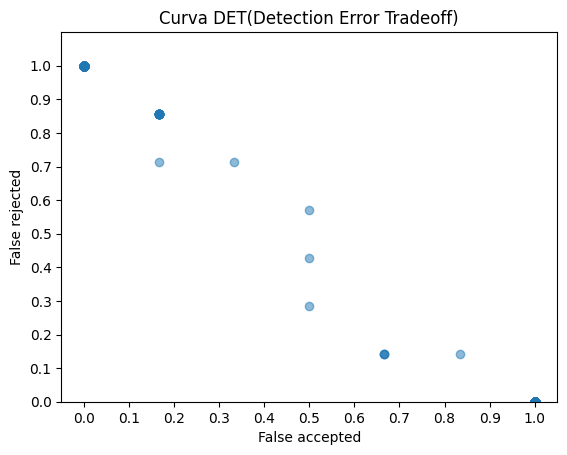

In [11]:
plt.plot(false_accepted, false_rejected, 'o', alpha=0.5)
plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.title("Curva DET(Detection Error Tradeoff)")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.1)
plt.show()

##### 1.1. EER (*Equal Error Rate*)

In [12]:
def identify_EER(far, frr):
    min_distance = float('inf')
    eer = 0
    eer_index = 0
    for i in range(len(far)):
        distance = abs(far[i] - frr[i])
        if distance < min_distance:
            min_distance = distance
            eer = (far[i] + frr[i]) / 2
            eer_index = i
    return eer, eer_index

##### 1.2. Ajuste de una curva aproximada

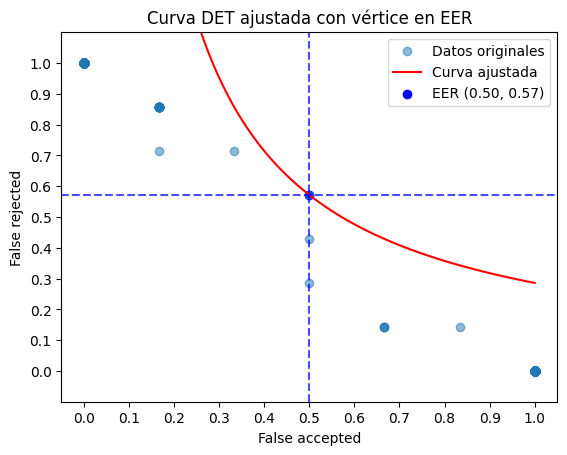

In [13]:
eer, eer_index = identify_EER(false_accepted, false_rejected)
x_vertex, y_vertex = false_accepted[eer_index], false_rejected[eer_index]

h = 0
a = (y_vertex - 0) * x_vertex
k = y_vertex - a / x_vertex

def rational_function(x):
    return a / (x - h) + k

x_smooth = np.linspace(0.07, 1, 500)
y_smooth = rational_function(x_smooth)

plt.plot(false_accepted, false_rejected, 'o', alpha=0.5, label="Datos originales")
plt.plot(x_smooth, y_smooth, '-', color='red', label=f"Curva ajustada")

plt.scatter([x_vertex], [y_vertex], color='blue', label=f"EER ({x_vertex:.2f}, {y_vertex:.2f})")
plt.axvline(x_vertex, color='blue', linestyle='--', alpha=0.7)
plt.axhline(y_vertex, color='blue', linestyle='--', alpha=0.7)

plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(-0.1, 1.1)
plt.title("Curva DET ajustada con vértice en EER")
plt.legend()
plt.show()


El sistema basado en SIFT muestra resultados relacionados con su desempeño en la gráfica DET (Detection Error Tradeoff), ajustada con un modelo matemático. La gráfica indica un Equal Error Rate (EER) de aproximadamente 0.5, lo que representa el punto en el cual las tasas de falsas aceptaciones y rechazos son iguales (0.5). Esto sugiere que el sistema tiene un balance moderado entre sensibilidad y especificidad, pero todavía deja margen para mejorar la discriminación en las decisiones. El ajuste con una curva matemática refuerza que el sistema puede modelarse y optimizarse para mejorar su desempeño.

#### 2. Función de Densidad de probabilidad (PDF)

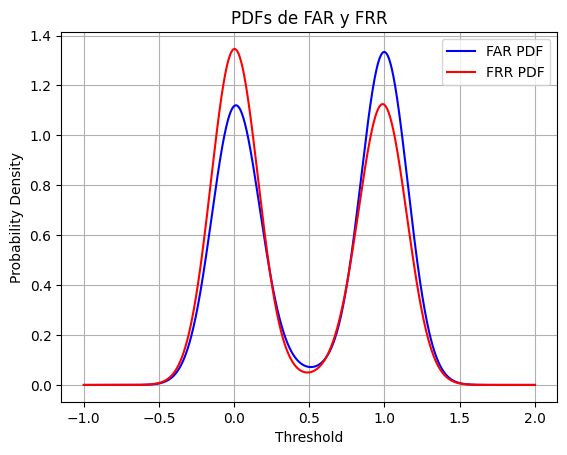

In [14]:
false_accepted = np.array(false_accepted)
false_rejected = np.array(false_rejected)

kde_far = gaussian_kde(false_accepted)
kde_frr = gaussian_kde(false_rejected)

x_range = np.linspace(-1, 2, 1000)

pdf_far = kde_far(x_range)
pdf_frr = kde_frr(x_range)

plt.plot(x_range, pdf_far, label="FAR PDF", color='blue')
plt.plot(x_range, pdf_frr, label="FRR PDF", color='red')

plt.xlabel("Threshold")
plt.ylabel("Probability Density")
plt.title("PDFs de FAR y FRR")
plt.legend()
plt.grid(True)
plt.show()


La región donde las curvas de FAR (en azul) y FRR (en rojo) se superponen indica el rango de umbrales donde ocurren errores en ambas tasas. Este rango es crítico porque señala la zona donde se determina el punto de operación del sistema.
La curva FAR está centrada hacia valores más altos de umbral, lo que indica que las falsas aceptaciones ocurren con mayor probabilidad a umbrales más altos.
La curva FRR está centrada hacia valores más bajos de umbral, lo que indica que los falsos rechazos ocurren con mayor probabilidad a umbrales más bajos.

#### 3. Curva ROC y AUC

In [15]:
true_positive_rates = []
false_positive_rates = []
thresholds = np.linspace(0, 500, 300)

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0
    true_positive = 0
    true_negative = 0
    total_positive = 0
    total_negative = 0

    for subfolder in subfolders:
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)

            result, img_name = find_match(new_des, users, threshold)

            if true_target == 1:
                total_positive += 1
                if int(result) == 1:
                    true_positive += 1
                else:
                    number_false_rejected += 1
            else:
                total_negative += 1
                if int(result) == 0:
                    true_negative += 1
                else:
                    number_false_accepted += 1

    tpr = true_positive / total_positive if total_positive else 0
    fpr = number_false_accepted / total_negative if total_negative else 0

    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)

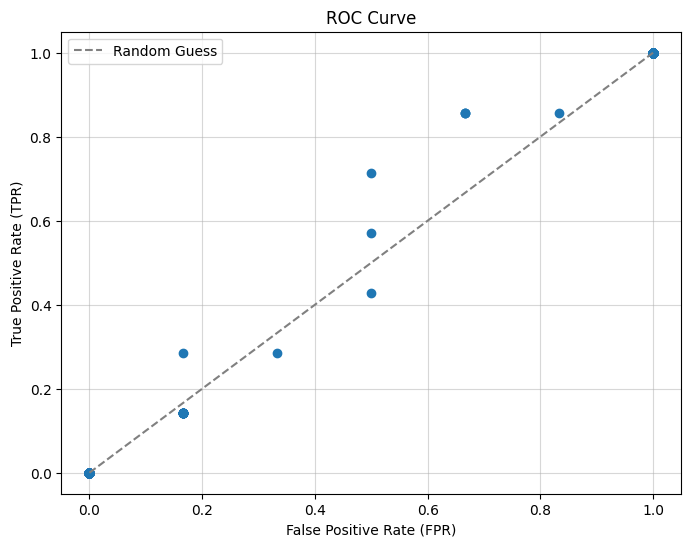

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rates, true_positive_rates, marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

##### 3.1. Ajuste de una curva aproximada

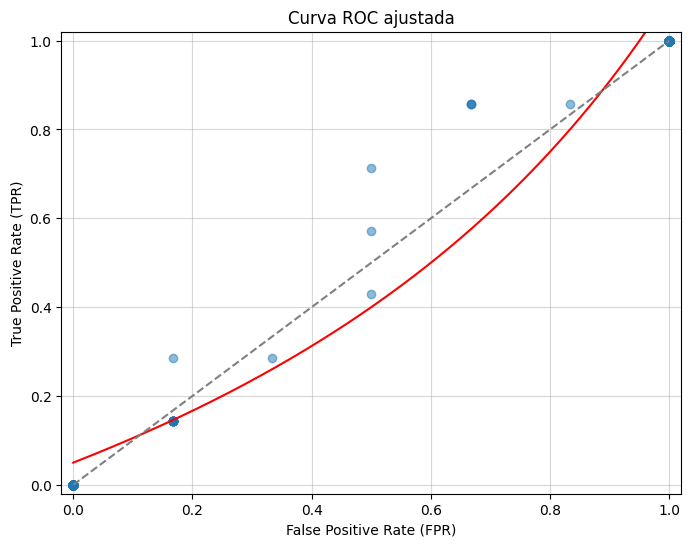

In [17]:
x_vertex, y_vertex = 0.5, 0.4
h = 2
k = -1  
a = (y_vertex - k) * (x_vertex - h)


x_smooth = np.linspace(0, 1, 500)
y_smooth = rational_function(x_smooth)

plt.figure(figsize=(8, 6))
plt.plot(false_positive_rates, true_positive_rates, 'o', alpha=0.5, label="Datos originales")
plt.plot(x_smooth, y_smooth, '-', color='red', label=f"Curva ajustada (a={a:.2f}, k={k:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.axvline(h, color='orange', linestyle='--', label="Asíntota vertical (x=0)")
plt.axhline(k, color='green', linestyle='--', label="Asíntota horizontal (y=0.6)")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC ajustada")
plt.ylim(-0.02, 1.02)
plt.xlim(-0.02, 1.02)
plt.grid(alpha=0.5)

plt.show()

En una curva ROC, la diagonal representa el desempeño de un clasificador aleatorio. Esto significa que no hay capacidad predictiva real, ya que la tasa de verdaderos positivos (TPR) aumenta al mismo ritmo que la tasa de falsos positivos (FPR).ç
La curva ROC (línea roja) está bastante cerca de esta diagonal. Esto sugiere que el modelo no está distinguiendo de manera efectiva entre las clases (por ejemplo, entre positivos y negativos).

In [18]:
roc_auc = auc(false_positive_rates, true_positive_rates)
print(f"Área bajo la curva (AUC): {roc_auc}")

Área bajo la curva (AUC): 0.5476190476190477


Además, el área bajo la curva (AUC) es de aproximadamente 0.5, lo que indica que el modelo no tiene capacidad predictiva. En otras palabras, el modelo no es mejor que un clasificador aleatorio.

#### 4. Accuracy

In [19]:
thresholds = np.linspace(0, 500, 300)
accuracies = []

int_usuario_no = 6
int_usuarios_si = 7

for threshold in thresholds:
    correct_predictions = 0
    total_predictions = 0

    for subfolder in subfolders:
        for file in os.listdir(dataset_path + '\\' + subfolder):
            path = dataset_path + '\\' + subfolder + '\\' + file
            true_target = targets[file]
            
            img = cv.imread(path)
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            sift = cv.SIFT_create()
            new_kp, new_des = sift.detectAndCompute(gray, None)
            result, img_name = find_match(new_des, users, threshold)

            if int(result) == true_target:
                correct_predictions += 1

            total_predictions += 1

    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

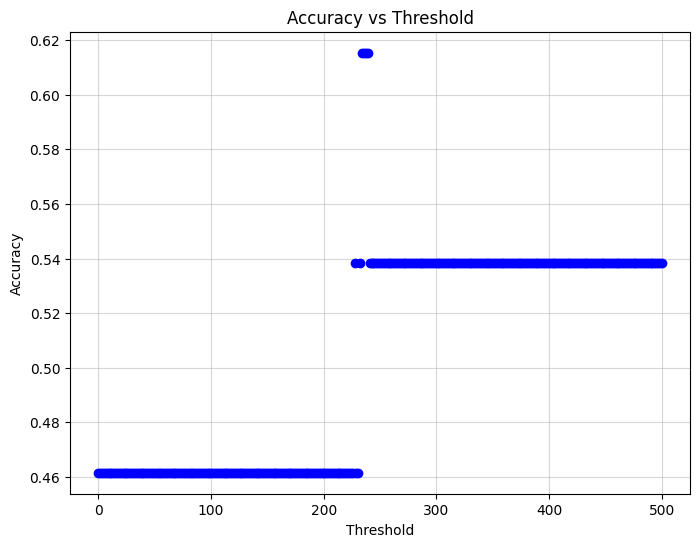

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, 'o', label='Accuracy', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(alpha=0.5)
plt.show()

In [26]:
best_accuracy_index = np.argmax(accuracies)  # Índice del mejor accuracy
best_threshold = thresholds[best_accuracy_index]
print(f"Mejor accuracy: {accuracies[best_accuracy_index]:.2f} con threshold = {best_threshold:.2f}")

Mejor accuracy: 0.62 con threshold = 234.11


In [27]:
print("\nEtiquetas clasificadas usando el mejor threshold:")

for subfolder in subfolders:
    for file in os.listdir(dataset_path + '\\' + subfolder):
        path = dataset_path + '\\' + subfolder + '\\' + file
        true_target = targets[file]
        
        img = cv.imread(path)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        sift = cv.SIFT_create()
        new_kp, new_des = sift.detectAndCompute(gray, None)
        result, img_name = find_match(new_des, users, best_threshold)
        predicted_label = "Valid" if int(result) == 1 else "Invalid"
        true_label = "Valid" if true_target == 1 else "Invalid"
        print(f"Archivo: {file} | Predicción: {predicted_label} | Verdadero: {true_label}")


Etiquetas clasificadas usando el mejor threshold:
Archivo: crd_0811s_01.png | Predicción: Invalid | Verdadero: Valid
Archivo: crd_0812s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0813s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0814s_01.png | Predicción: Invalid | Verdadero: Valid
Archivo: crd_0815s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0816s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0817s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0818f_01.png | Predicción: Invalid | Verdadero: Invalid
Archivo: crd_0818s_01.png | Predicción: Valid | Verdadero: Invalid
Archivo: crd_0819f_01.png | Predicción: Valid | Verdadero: Invalid
Archivo: crd_0819s_01.png | Predicción: Valid | Verdadero: Invalid
Archivo: crd_0820f_01.png | Predicción: Invalid | Verdadero: Invalid
Archivo: crd_0820s_01.png | Predicción: Invalid | Verdadero: Invalid


### 2.2. ResNet pre-entrenada

Este sistema consiste en:
1. Extraer el vector latente de las imágenes de los usuarios del sistema mediante la red convolutiva `ResNet50` preentrenada.
2. Comparar la distancia coseno entre los vectores latentes de las imágenes de los usuarios.
3. Si la distancia más pequeña es menor que un umbral, se acepta y si no, se rechaza.

In [28]:
def extract_features(img_path, model):
    model.eval()
    image = cv.imread(img_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        features = model(image).squeeze().numpy()
    return features

def compare_fingerprints(users, v2, threshold=0.1):
    for _, user in enumerate(users):
        user = user.flatten() if user.ndim > 1 else user
        v2 = v2.flatten() if v2.ndim > 1 else v2
        
        distance = cosine(user, v2)
        if distance < threshold:
            return True
    return False

def system(route, model, users, threshold=0.2):
    v2 = extract_features(route, model)
    return compare_fingerprints(users, v2, threshold)

In [29]:
warnings.filterwarnings("ignore")
model = models.resnet50(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])

In [30]:
users = []
sample_path = r"\BaseDatosNISTsd09_pr"
dataset_path = "./datasets/hand_dataset"
sample_path = os.getcwd() + sample_path
subfolders = os.listdir(sample_path)

for i, subfolder in enumerate(subfolders[:6]):
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]
    vector = extract_features(route, model)
    users.append(vector)

# Eliminar los usuarios ya registrados
i = 0
for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    route = dataset_path + '\\' + subfolder + '\\' + path[0]
    os.remove(route)
    if i == 6:
        break
    i += 1

#### 1. Curva DET (*Detection Error Tradeoff*)

In [31]:
correct = 0
true_positive = 0
true_negative = 0
total = 0

thresholds = np.linspace(0, 1, 100)
false_accepted = []
false_rejected = []
int_usuario_no = 6
int_usuarios_si = 7

distances = []
labels = []

for threshold in thresholds:
    number_false_rejected = 0
    number_false_accepted = 0

    for subfolder in subfolders:
        path = os.listdir(dataset_path + '\\' + subfolder)
        
        for file_name in path:
            route = dataset_path + '\\' + subfolder + '\\' + file_name
            true_target = targets[file_name]
            
            result = system(route, model, users, threshold)
            
            if int(result) == 0 and true_target == 1:
                number_false_rejected += 1
            
            elif int(result) == 1 and true_target == 0:
                number_false_accepted += 1
            
            elif int(result) == true_target:
                correct += 1
            total += 1
    far = number_false_accepted / int_usuario_no
    frr = number_false_rejected / int_usuarios_si

    false_accepted.append(far)
    false_rejected.append(frr)


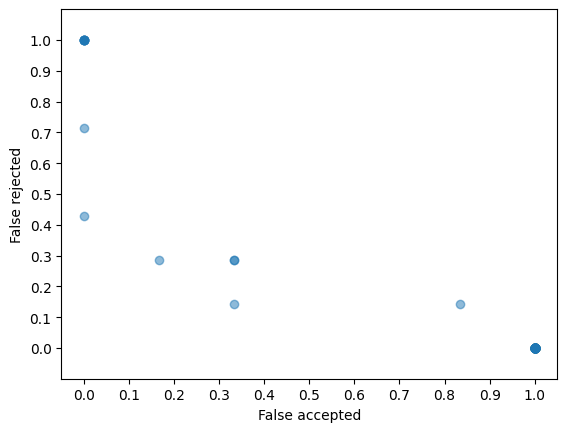

In [34]:
plt.plot(false_accepted, false_rejected, 'o', alpha=0.5)
plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(-0.1, 1.1)
plt.show()

##### 1.1. EER (*Equal Error Rate*)

EER: 0.31


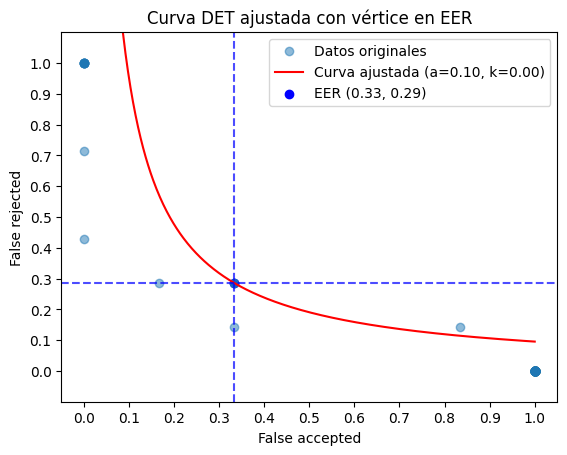

In [35]:
eer, eer_index = identify_EER(false_accepted, false_rejected)
print(f"EER: {eer:.2f}")
x_vertex, y_vertex = false_accepted[eer_index], false_rejected[eer_index]

h = 0
a = (y_vertex - 0) * x_vertex
k = y_vertex - a / x_vertex

def rational_function(x):
    return a / (x - h) + k

x_smooth = np.linspace(0.07, 1, 500)
y_smooth = rational_function(x_smooth)

plt.plot(false_accepted, false_rejected, 'o', alpha=0.5, label="Datos originales")
plt.plot(x_smooth, y_smooth, '-', color='red', label=f"Curva ajustada (a={a:.2f}, k={k:.2f})")

plt.scatter([x_vertex], [y_vertex], color='blue', label=f"EER ({x_vertex:.2f}, {y_vertex:.2f})")
plt.axvline(x_vertex, color='blue', linestyle='--', alpha=0.7)
plt.axhline(y_vertex, color='blue', linestyle='--', alpha=0.7)

plt.xlabel("False accepted")
plt.ylabel("False rejected")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(-0.1, 1.1)
plt.title("Curva DET ajustada con vértice en EER")
plt.legend()
plt.show()

Este sistema tiene un desempeño moderado, con errores significativos tanto de aceptación como de rechazo. El EER en 30% indica que el sistema necesita mejoras si se busca una solución práctica y robusta.

#### 2. Densidad de probabilidad

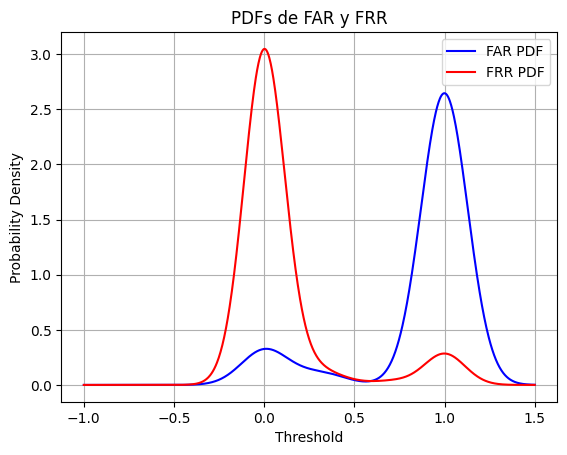

In [36]:
false_accepted = np.array(false_accepted)
false_rejected = np.array(false_rejected)

kde_far = gaussian_kde(false_accepted)
kde_frr = gaussian_kde(false_rejected)

x_range = np.linspace(-1, 1.5, 1000)

pdf_far = kde_far(x_range)
pdf_frr = kde_frr(x_range)

plt.plot(x_range, pdf_far, label="FAR PDF", color='blue')
plt.plot(x_range, pdf_frr, label="FRR PDF", color='red')

plt.xlabel("Threshold")
plt.ylabel("Probability Density")
plt.title("PDFs de FAR y FRR")
plt.legend()
plt.grid(True)
plt.show()


Este comportamiento es indicativo de un sistema razonablemente bien diseñado. Las separaciones de las distribuciones muestran que la ResNet50 preentrenada puede extraer características latentes útiles para distinguir usuarios genuinos de impostores. La métrica de distancia coseno parece ser efectiva para comparar vectores latentes en este caso.
- Posibles limitaciones:
Aunque la superposición entre las distribuciones es mínima, su existencia implica que para ciertos valores de umbral, todavía ocurrirán errores, lo que podría no ser ideal en aplicaciones de alta seguridad.

- Ajuste del umbral:
El umbral debe ajustarse en función del contexto de la aplicación:
Si la seguridad es crítica (evitar FAR), se seleccionará un umbral más alto.
Si la conveniencia del usuario es prioritaria (evitar FRR), se seleccionará un umbral más bajo.

#### 3. Curva ROC y AUC

In [50]:
false_positive_rate = []
true_positive_rate = []

thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for subfolder in subfolders:
        path = os.listdir(dataset_path + '\\' + subfolder)
        
        for file_name in path:
            route = dataset_path + '\\' + subfolder + '\\' + file_name
            true_target = targets[file_name]
            
            result = system(route, model, users, threshold)

            if int(result) == 1 and true_target == 1:
                true_positive += 1
            elif int(result) == 1 and true_target == 0:
                false_positive += 1
            elif int(result) == 0 and true_target == 0:
                true_negative += 1
            elif int(result) == 0 and true_target == 1:
                false_negative += 1

    if (true_positive + false_negative) > 0:
        tpr = true_positive / (true_positive + false_negative)
    else:
        tpr = 0

    if (false_positive + true_negative) > 0:
        fpr = false_positive / (false_positive + true_negative)
    else:
        fpr = 0

    true_positive_rate.append(tpr)
    false_positive_rate.append(fpr)

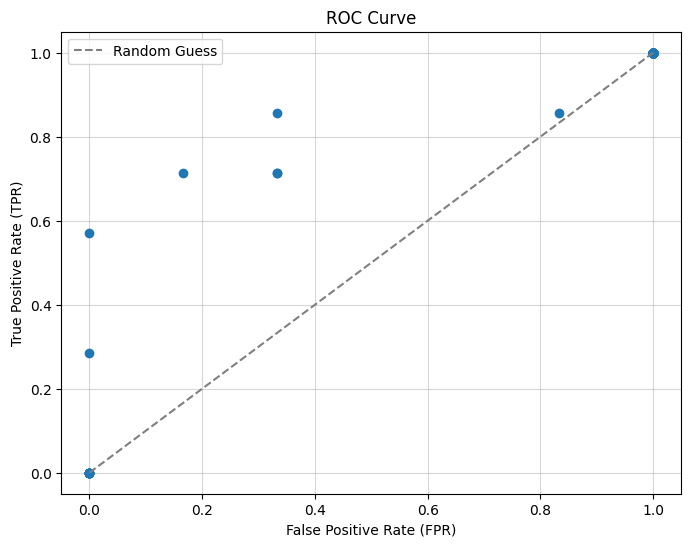

In [51]:
plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, marker='o', linestyle='')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

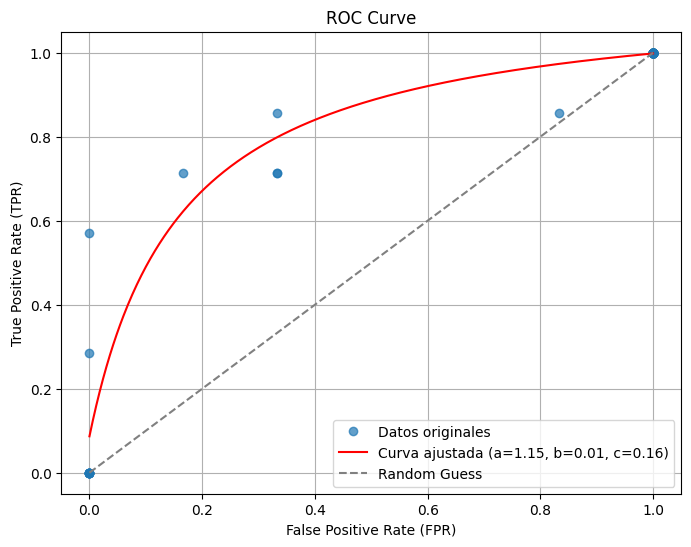

In [56]:
def rational_function(x, a, b, c):
    return (a * x + b) / (x + c)

popt, pcov = curve_fit(rational_function, false_positive_rate, true_positive_rate)

a, b, c = popt
fpr_smooth = np.linspace(0, 1, 500)
tpr_smooth = rational_function(fpr_smooth, a, b, c)

diff = np.abs(fpr_smooth - tpr_smooth)
vertex_index = np.argmin(diff)
vertex = (fpr_smooth[vertex_index], tpr_smooth[vertex_index])

plt.figure(figsize=(8, 6))
plt.plot(false_positive_rate, true_positive_rate, 'o', label='Datos originales', alpha=0.7)
plt.plot(fpr_smooth, tpr_smooth, 'r-', label=f'Curva ajustada (a={a:.2f}, b={b:.2f}, c={c:.2f})')
plt.plot([0, 1], [0, 1], '--', label='Random Guess', color='gray')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

La forma de la curva sugiere que el sistema logra una buena discriminación entre clases (usuarios aceptados y rechazados), con una Tasa de Verdaderos Positivos (TPR) relativamente alta incluso para bajos valores de la Tasa de Falsos Positivos (FPR). Esto significa que el sistema es capaz de identificar correctamente a los usuarios legítimos con una baja incidencia de aceptaciones incorrectas. Sin embargo, para un sistema basado en reconocimiento biométrico, se debe analizar si la relación entre FPR y TPR es suficiente para cumplir con los requisitos de seguridad y usabilidad. Además, la elección del umbral afecta directamente este balance, y una optimización cuidadosa puede mejorar aún más el rendimiento.

In [57]:
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f"Área bajo la curva (AUC): {roc_auc}")

Área bajo la curva (AUC): 0.8095238095238094


#### 4. Accuracy

In [58]:
thresholds = np.linspace(0, 1, 100)
accuracies = []

int_usuario_no = 6
int_usuarios_si = 7

for threshold in thresholds:
    correct_predictions = 0
    total_predictions = 0

    for subfolder in subfolders:
        path = os.listdir(dataset_path + '\\' + subfolder)
        
        for file_name in path:
            route = dataset_path + '\\' + subfolder + '\\' + file_name
            true_target = targets[file_name]
            v2 = extract_features(route, model)
            
            result = compare_fingerprints(users, v2, threshold)

            if int(result) == true_target:
                correct_predictions += 1
            
            total_predictions += 1

    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)

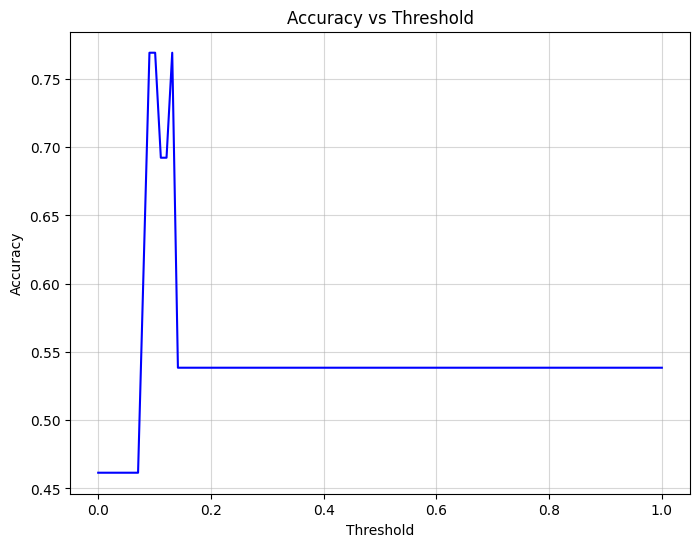

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracies, label='Accuracy', color='blue')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(alpha=0.5)
plt.show()

In [60]:
best_accuracy_index = np.argmax(accuracies)  # Índice del mejor accuracy
best_threshold = thresholds[best_accuracy_index]
print(f"Mejor accuracy: {accuracies[best_accuracy_index]:.2f} con threshold = {best_threshold:.2f}")

Mejor accuracy: 0.77 con threshold = 0.09


In [61]:
print("\nEtiquetas clasificadas usando el mejor threshold:")

for subfolder in subfolders:
    path = os.listdir(dataset_path + '\\' + subfolder)
    
    for file_name in path:
        route = dataset_path + '\\' + subfolder + '\\' + file_name
        true_target = targets[file_name]

        result = system(route, model, users, best_threshold)
        
        predicted_label = "Valid" if int(result) == 1 else "Invalid"
        true_label = "Valid" if true_target == 1 else "Invalid"
        
        print(f"Archivo: {file_name} | Predicción: {predicted_label} | Verdadero: {true_label}")


Etiquetas clasificadas usando el mejor threshold:
Archivo: crd_0811s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0812s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0813s_01.png | Predicción: Invalid | Verdadero: Valid
Archivo: crd_0814s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0815s_01.png | Predicción: Invalid | Verdadero: Valid
Archivo: crd_0816s_01.png | Predicción: Invalid | Verdadero: Valid
Archivo: crd_0817s_01.png | Predicción: Valid | Verdadero: Valid
Archivo: crd_0818f_01.png | Predicción: Invalid | Verdadero: Invalid
Archivo: crd_0818s_01.png | Predicción: Invalid | Verdadero: Invalid
Archivo: crd_0819f_01.png | Predicción: Invalid | Verdadero: Invalid
Archivo: crd_0819s_01.png | Predicción: Invalid | Verdadero: Invalid
Archivo: crd_0820f_01.png | Predicción: Invalid | Verdadero: Invalid
Archivo: crd_0820s_01.png | Predicción: Invalid | Verdadero: Invalid


### 2.3 Red Convolutiva desde cero

In [40]:
import os
import torch
import cv2 as cv
import numpy as np

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, auc, det_curve
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, classification_report

import matplotlib.pyplot as plt

#### Data Augmentation

In [ ]:
def generate_rotated_img(img, angle, base_name, extension, root):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv.warpAffine(img, M, (w, h))
    rotated_image_path = os.path.join(root, f"{base_name}_{angle}_grades{extension}")
    cv.imwrite(rotated_image_path, rotated_img)

def rotate_images_in_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                image_path = os.path.join(root, file)
                img = cv.imread(image_path)
                base_name = os.path.splitext(file)[0]
                extension = os.path.splitext(file)[1]
                for angle in range(1, 181):
                    generate_rotated_img(img, angle, base_name, extension, root)

#### Identificación y autentificación

In [62]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(10),  # Menor rotación
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset_train = ImageFolder("./datasets/conv_auten_train", transform=transform_train)
dataset = ImageFolder("./datasets/conv_auten_test", transform=transform_test)

train_size = int(0.7 * len(dataset_train))
test_size = int(0.2 * len(dataset_train)) 
eval_size = len(dataset_train) - train_size - test_size
train_dataset, _, _ = random_split(dataset_train, [train_size, test_size, eval_size])

_ = int(0.6 * len(dataset))
test_size = int(0.3 * len(dataset))
eval_size = len(dataset) - _ - test_size
test_dataset, eval_dataset ,_ = random_split(dataset, [test_size, eval_size ,_])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [60]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet()
class_counts = [1267, 543]  # Actualiza según tus datos
class_weights = torch.tensor([1.0 / class_counts[0], 2.0 / class_counts[1]], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)

num_epochs = 10
patience = 5  # Número de épocas sin mejora antes de detener el entrenamiento
best_val_loss = float('inf')  # La mejor pérdida de validación registrada
epochs_no_improve = 0  # Contador de épocas sin mejora

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluar en validación
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(eval_loader)
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")

    # Early Stopping: Verificar mejora en la pérdida de validación
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

# Evaluación final en el conjunto de prueba
correct = 0
total = 0

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convertir las listas a arrays
all_probs = np.vstack(all_probs)
all_labels = np.concatenate(all_labels)

# Métricas
predictions = np.argmax(all_probs, axis=1)
accuracy = accuracy_score(all_labels, predictions)
balanced_acc = balanced_accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions, average='binary')
recall = recall_score(all_labels, predictions, average='binary')
f1 = f1_score(all_labels, predictions, average='binary')

print(classification_report(all_labels, predictions, target_names=["auten", "non_auten"]))
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")



Epoch 1/10, Loss: 0.6520, Validation Loss: 0.6205, Validation Accuracy: 0.33
Epoch 2/10, Loss: 0.6133, Validation Loss: 0.6271, Validation Accuracy: 0.33
No improvement in validation loss for 1 epoch(s).
Epoch 3/10, Loss: 0.5844, Validation Loss: 0.6180, Validation Accuracy: 0.33
Epoch 4/10, Loss: 0.5452, Validation Loss: 0.6328, Validation Accuracy: 0.35
No improvement in validation loss for 1 epoch(s).
Epoch 5/10, Loss: 0.4777, Validation Loss: 0.6929, Validation Accuracy: 0.51
No improvement in validation loss for 2 epoch(s).
Epoch 6/10, Loss: 0.4129, Validation Loss: 0.7927, Validation Accuracy: 0.54
No improvement in validation loss for 3 epoch(s).
Epoch 7/10, Loss: 0.3551, Validation Loss: 0.9057, Validation Accuracy: 0.53
No improvement in validation loss for 4 epoch(s).
Epoch 8/10, Loss: 0.2863, Validation Loss: 1.1808, Validation Accuracy: 0.49
No improvement in validation loss for 5 epoch(s).
Early stopping triggered.
              precision    recall  f1-score   support

   

##### FAR y FRR

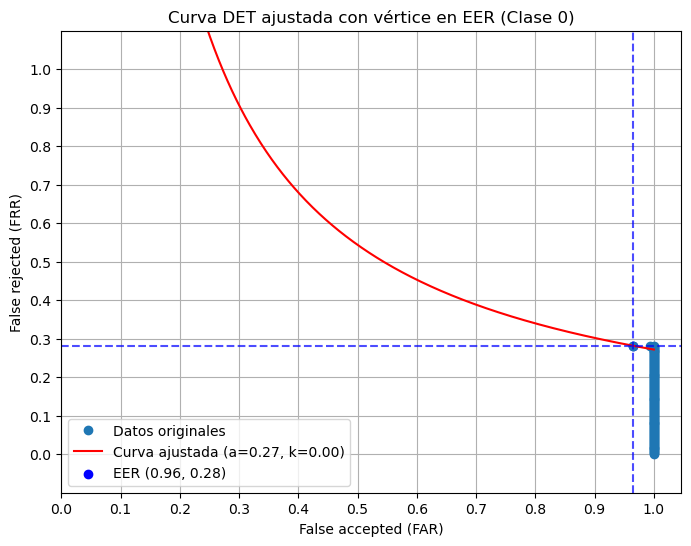

Clase 0: EER = 62.33% at Threshold: 1.0000


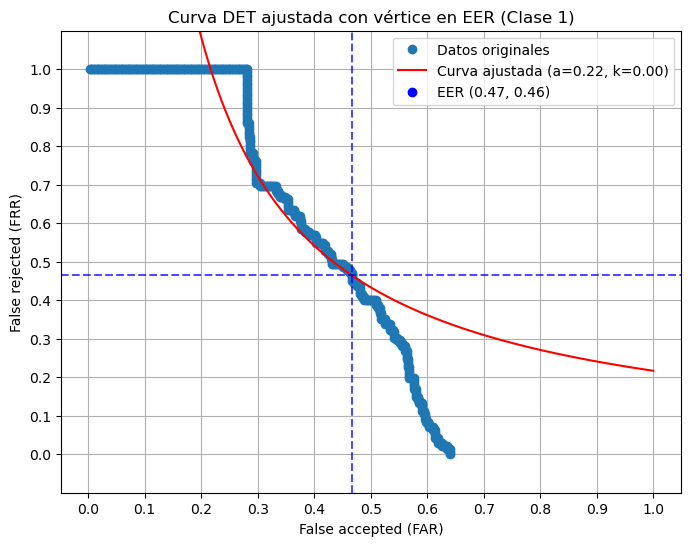

Clase 1: EER = 46.56% at Threshold: 0.0000


In [10]:
n_classes = all_probs.shape[1]

# Función para identificar el EER y su índice
def identify_EER(far, frr):
    min_distance = float('inf')
    eer = 0
    eer_index = 0
    for i in range(len(far)):
        distance = abs(far[i] - frr[i])
        if distance < min_distance:
            min_distance = distance
            eer = (far[i] + frr[i]) / 2
            eer_index = i
    return eer, eer_index

# Generar gráficos DET para cada clase
for class_index in range(n_classes):
    # Convertir etiquetas a binario (one-vs-rest)
    true_labels = (all_labels == class_index).astype(int)
    decision_scores = all_probs[:, class_index]

    # Calcular las tasas FAR, FRR y los umbrales
    false_accepted, false_rejected, thresholds = det_curve(true_labels, decision_scores)

    # Calcular el EER
    eer, eer_index = identify_EER(false_accepted, false_rejected)
    x_vertex, y_vertex = false_accepted[eer_index], false_rejected[eer_index]

    # Definir la función racional para ajustar la curva
    h = 0
    a = (y_vertex - 0) * x_vertex
    k = y_vertex - a / x_vertex

    def rational_function(x):
        return a / (x - h) + k

    # Generar valores suaves para la curva ajustada
    x_smooth = np.linspace(0.07, 1, 500)
    y_smooth = rational_function(x_smooth)

    # Graficar los datos originales y la curva ajustada
    plt.figure(figsize=(8, 6))
    plt.plot(false_accepted, false_rejected, 'o', label="Datos originales")
    plt.plot(x_smooth, y_smooth, '-', color='red', label=f"Curva ajustada (a={a:.2f}, k={k:.2f})")

    # Marcar el EER
    plt.scatter([x_vertex], [y_vertex], color='blue', label=f"EER ({x_vertex:.2f}, {y_vertex:.2f})")
    plt.axvline(x_vertex, color='blue', linestyle='--', alpha=0.7)
    plt.axhline(y_vertex, color='blue', linestyle='--', alpha=0.7)

    # Configuración de la gráfica
    plt.xlabel("False accepted (FAR)")
    plt.ylabel("False rejected (FRR)")
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylim(-0.1, 1.1)
    plt.title(f"Curva DET ajustada con vértice en EER (Clase {class_index})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Imprimir el valor del EER
    print(f"Clase {class_index}: EER = {eer:.2%} at Threshold: {thresholds[eer_index]:.4f}")

##### Densidad de probabilidad

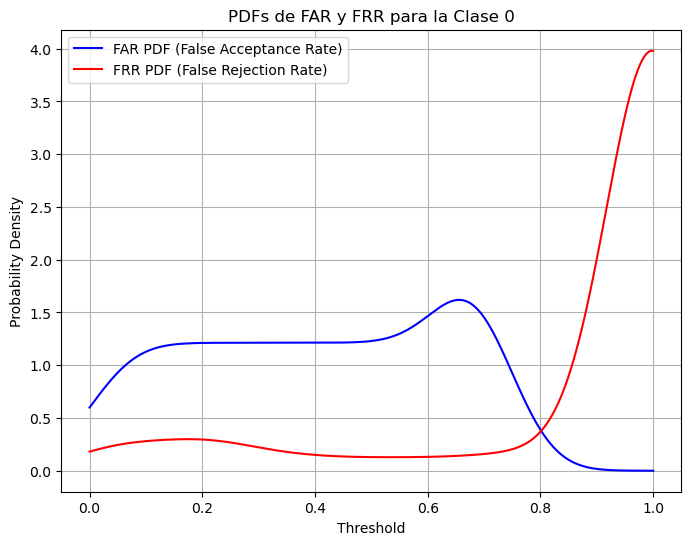

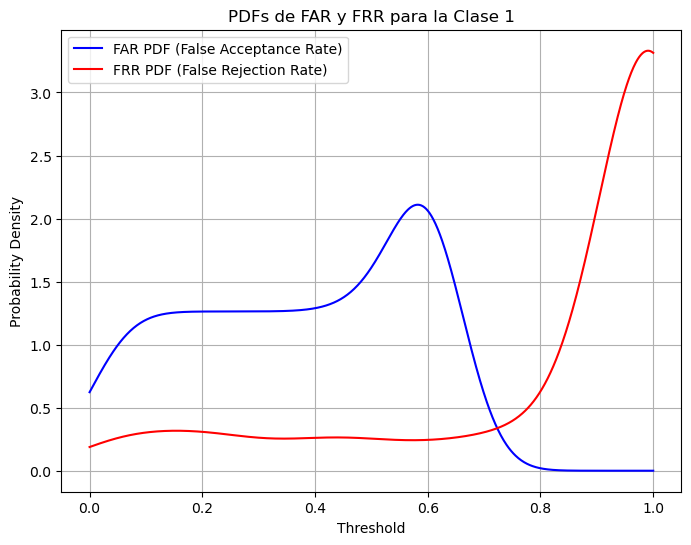

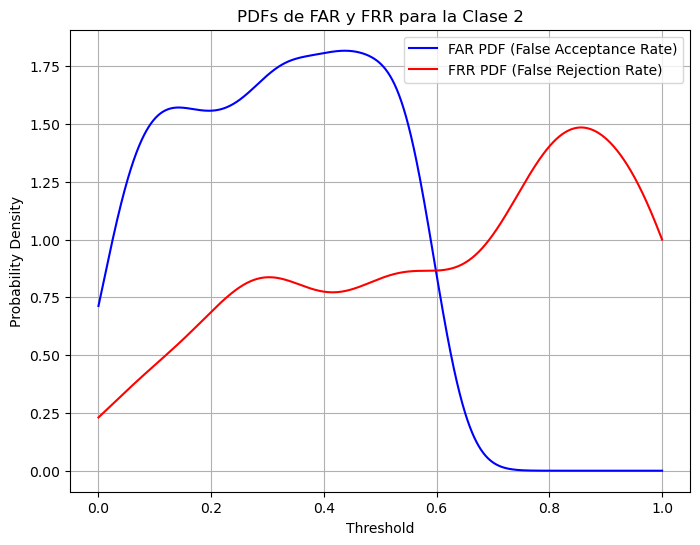

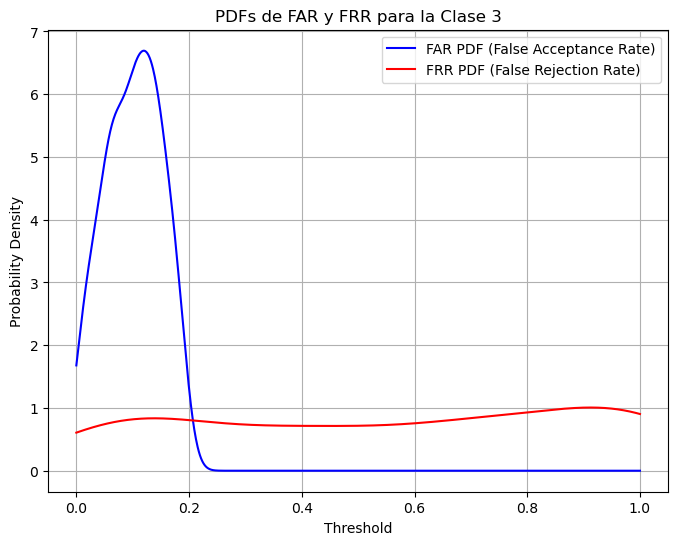

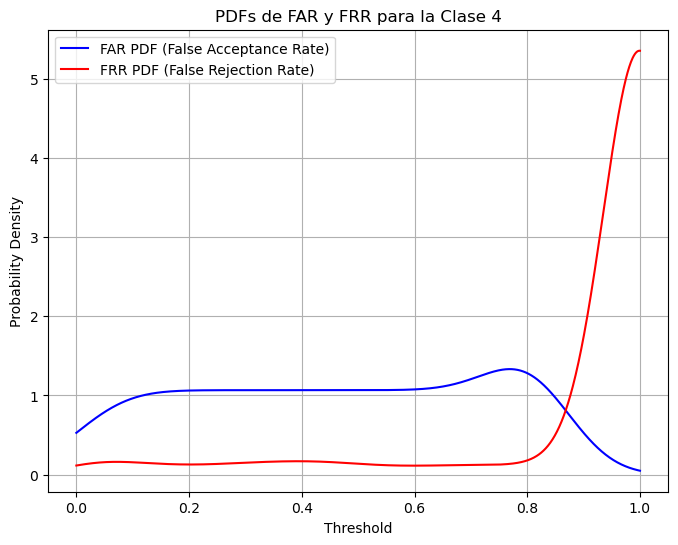

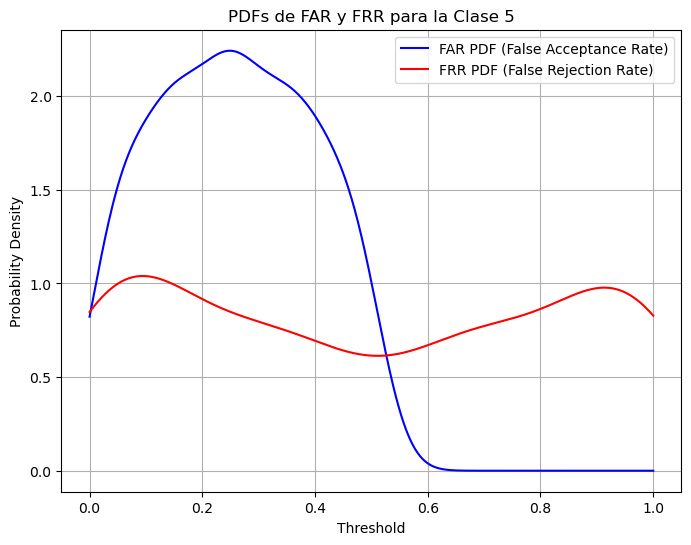

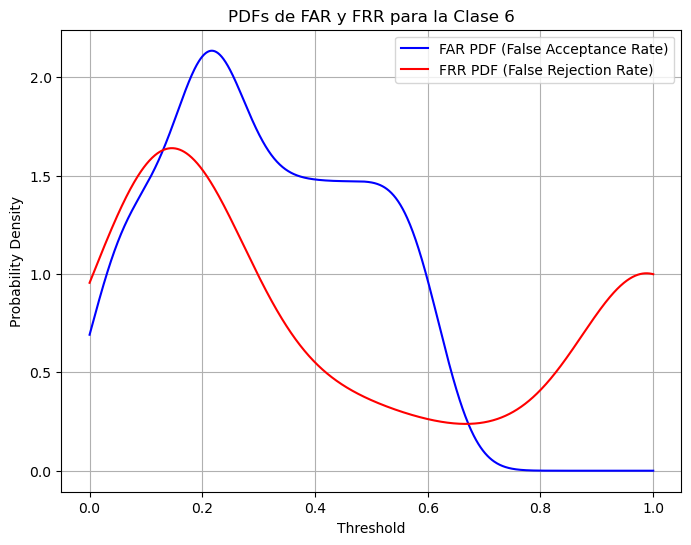

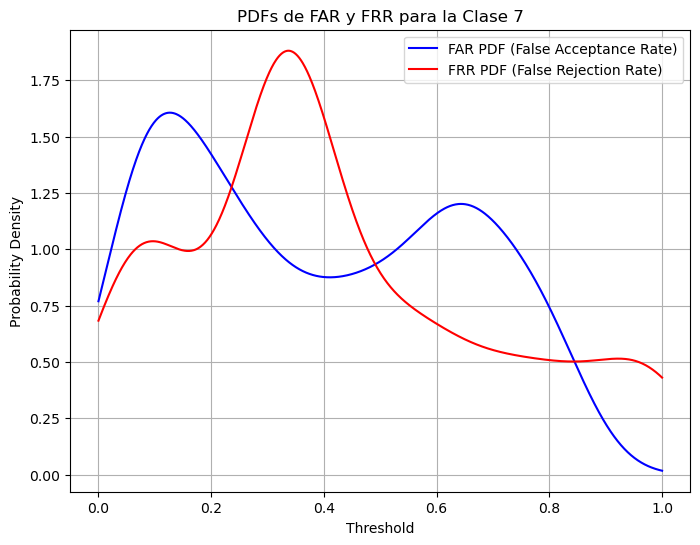

In [ ]:


# Asegúrate de que `all_labels` y `all_probs` ya estén definidos
# Número de clases en el conjunto de datos
n_classes = all_probs.shape[1]

# Iterar sobre todas las clases
for class_index in range(n_classes):
    # Convertir etiquetas a binario (one-vs-rest)
    binary_labels = (all_labels == class_index).astype(int)
    
    # Calcular las curvas FAR, FRR y los umbrales para la clase actual
    fpr, fnr, thresholds = det_curve(binary_labels, all_probs[:, class_index])
    
    # FAR (False Acceptance Rate) y FRR (False Rejection Rate)
    false_accepted = fpr
    false_rejected = fnr
    
    # Crear objetos KDE para FAR y FRR
    kde_far = gaussian_kde(false_accepted)
    kde_frr = gaussian_kde(false_rejected)
    
    # Definir el rango de umbrales para calcular las PDFs
    x_range = np.linspace(0, 1, 1000)
    
    # Calcular las densidades de probabilidad
    pdf_far = kde_far(x_range)
    pdf_frr = kde_frr(x_range)
    
    # Graficar las PDFs para la clase actual
    plt.figure(figsize=(8, 6))
    plt.plot(x_range, pdf_far, label="FAR PDF (False Acceptance Rate)", color='blue')
    plt.plot(x_range, pdf_frr, label="FRR PDF (False Rejection Rate)", color='red')
    
    plt.xlabel("Threshold")
    plt.ylabel("Probability Density")
    plt.title(f"PDFs de FAR y FRR para la Clase {class_index}")
    plt.legend()
    plt.grid(True)
    plt.show()


##### Curva ROC y AUC

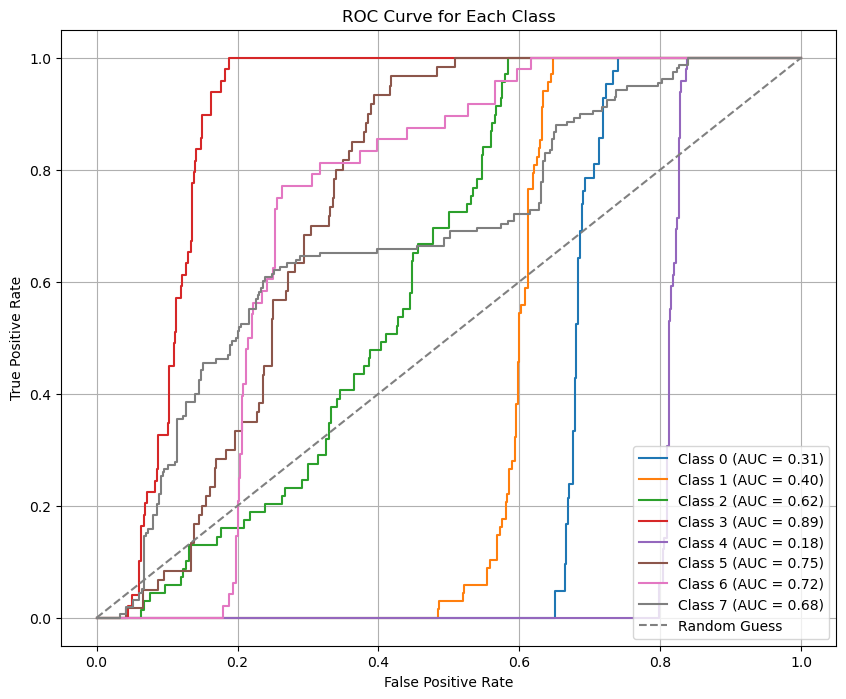

AUC por clase:
Clase 0: AUC = 0.31
Clase 1: AUC = 0.40
Clase 2: AUC = 0.62
Clase 3: AUC = 0.89
Clase 4: AUC = 0.18
Clase 5: AUC = 0.75
Clase 6: AUC = 0.72
Clase 7: AUC = 0.68


In [ ]:
# Obtener el número de clases
n_classes = all_probs.shape[1]

# Convertir las etiquetas a formato binario (one-hot encoding)
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Inicializar variables para almacenar las curvas ROC y AUC
fpr = {}
tpr = {}
roc_auc = {}

# Generar la curva ROC y calcular el AUC para cada clase
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    # Calcular FPR, TPR y umbrales para la clase i
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficar la curva ROC para la clase i
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Agregar línea base para adivinar al azar
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")

# Configuración de la gráfica
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Imprimir los AUC para cada clase
print("AUC por clase:")
for i in range(n_classes):
    print(f"Clase {i}: AUC = {roc_auc[i]:.2f}")


### 3. Definición de las medidas utilizadas

#### 1. Curva DET (*Detection Error Tradeoff*)

La curva DET es un gráfico que muestra la relación entre las tasas de error de un sistema, en particular:
- **FAR (*False Acceptance Rate*)**: Tasa de falsas aceptaciones (también conocido como tasa de falsos positivos).
- **FRR (*False Rejection Rate*)**: Tasa de rechazos falsos (también conocido como tasa de falsos negativos).

Además, debido a la falta de datos, se ha ajustado una curva aproximada para cada uno de los sistemas.

#### 2.  EER (*Equal Error Rate*)

El EER es el punto donde la FAR y la FRR son iguales. En otras palabras, es el punto de intersección entre ambas tasas cuando se grafican frente al umbral de decisión.

#### 3. Densidad de probabilidad

La función de densidad de probabilidad (PDF) describe cómo se distribuyen las probabilidades de las variables aleatorias en un dominio continuo. La PDF proporciona una forma de representar y analizar la probabilidad de que una variable tome ciertos valores dentro de un rango específico.

Se realiza mediante la función `gaussian_kde` la cual es una función de Kernel Density Estimation (Estimación de Densidad por Kernel) que permite ajustar una distribución de probabilidad suavizada a los datos proporcionados.


#### 4. Curva ROC y AUC

La curva ROC (*Receiver Operating Characteristic*) es una representación gráfica que evalúa el rendimiento de un clasificador binario en función de diferentes umbrales de decisión. 
El AUC (*Area Under the Curve*) es una métrica derivada de la curva ROC que mide el área bajo la curva ROC.

### 4. Recopilatorio de las tres hipótesis principales